# PHYS 381 - Final Exam#
### Siegfried Peschke - 30032136
#### April 5, 2019

## Introduction

We are given a dataset which is a record of carbon dioxide concentrations at Mauna Loa Observatory, Hawaii. The data collection began in 1958 and continues to date.

For each measurement given on a decimal date, there is 3 different sets of data; average, interpolated, and trend counts of $CO_2$ expressed as a mole fraction in the dry air. The interpolated set is required to fill in some missing data points and the trend set accounts for a monthly seasonal correction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

## Task 1 - Fit the Data with Polynomials
Use `numpy.genfromtxt` to read columns 2 (decimal date) and 4 (interpolated CO2) and use these data for all subsequent analysis. Then fit the entire sequence of CO2 observations as a function of date with polynomials of degree 1 through 5. Plot the residuals, tabulate the values of $\chi^2$, and comment on the results.

In [2]:
#Import the data
filepath = 'C:\\Users\\Sigi Peschke\\OneDrive\\PHYS 381\\co2_mm_mlo.txt' #PC
#filepath = 'C:\\Users\sigip\\OneDrive\\PHYS 381\\co2_mm_mlo.txt' #Laptop

data = np.genfromtxt(filepath, skip_header=72, max_rows=804, usecols=(0,1,2,4), 
                     names=['year', 'month', 'ddate', 'interpolated'])

ddate_data, interpolated_data = data['ddate'], data['interpolated']

We will attempt to fit the data using polynomials. Assuming a function with dependent variable $x$, $g(x)$, with the tabulated values $g_i = g(x_i)$ and assuming that $g(x)$ can be approximated as an (n-1) degree polynomial where $(x \approx x_i)$, we can model the relationship as follows:

$$ g_i(x) \approx a_0 + a_1x + a_2x^2 + ... + a_{n-1}x^{n-1}$$

The function np.polyfit does this for us by returning a vector of coefficients that minimizes the squared error in the order n, n-1, ..., 0.

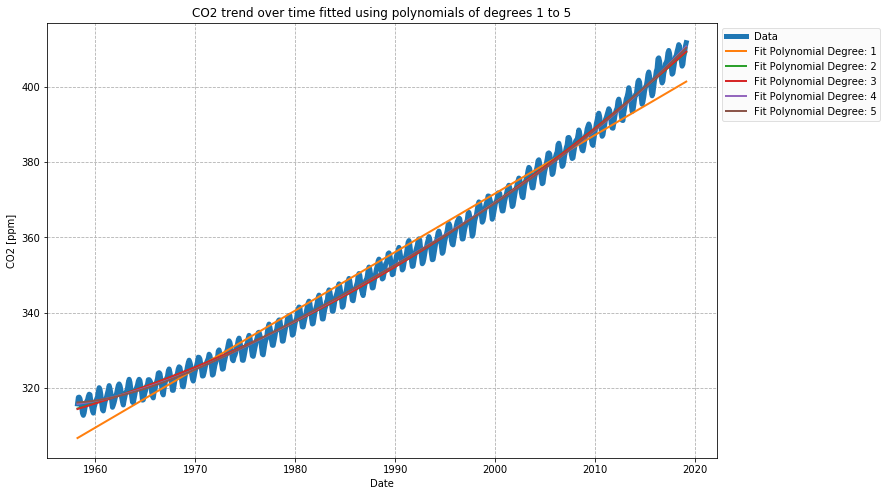

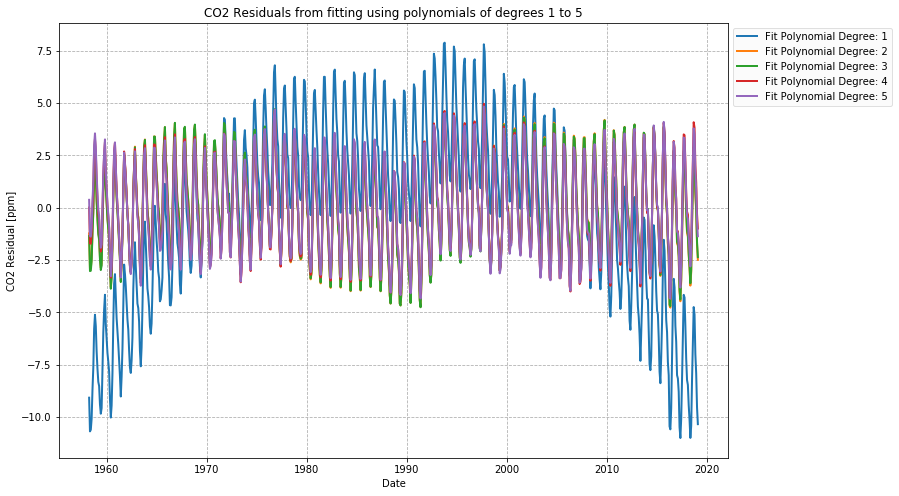

In [3]:
#Gridlines
plt.figure(figsize=(12,8))
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Date')
plt.ylabel('CO2 [ppm]')
plt.title("CO2 trend over time fitted using polynomials of degrees 1 to 5")

#Plot the data
plt.plot(ddate_data, interpolated_data, lw = 5, label = 'Data')

#Create fits and plot them
residual_list = []
for indx, deg in enumerate([1,2,3,4,5]):
    poly_coeffs = np.polyfit(ddate_data, interpolated_data, deg)
    ypoly_vals = np.polyval(poly_coeffs, ddate_data)
    plt.plot(ddate_data, ypoly_vals, lw = 2, label = 'Fit Polynomial Degree: ' + str(deg))
    residual_list.append(ypoly_vals - interpolated_data)

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

#Gridlines
plt.figure(figsize=(12,8))
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Date')
plt.ylabel('CO2 Residual [ppm]')
plt.title("CO2 Residuals from fitting using polynomials of degrees 1 to 5")

#Plot the residuals
deg = 1
for residuals in residual_list:
    plt.plot(ddate_data, residuals, lw = 2, label = 'Fit Polynomial Degree: ' + str(deg))
    deg += 1

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

Now to calculate the $\chi^2$ values for each polynomial fit, we can take the data from 'residual_list', square each residual point and sum them, according to

$$ \chi^2 = \sum | y_i - \tilde y_i(p_1,\ldots,p_K) |^2 $$

In [4]:
degree = 1
for deg in residual_list:
    chi = 0
    for i in deg:
        chi += i*i
    print("Fit Polynomial Degree: " + str(degree))
    print('\t Associated x^2 value: %0.2f' %chi)
    degree += 1

Fit Polynomial Degree: 1
	 Associated x^2 value: 12660.76
Fit Polynomial Degree: 2
	 Associated x^2 value: 3573.48
Fit Polynomial Degree: 3
	 Associated x^2 value: 3571.71
Fit Polynomial Degree: 4
	 Associated x^2 value: 3416.06
Fit Polynomial Degree: 5
	 Associated x^2 value: 3406.77


Looking at the graph of the fits, only the polynomial of degree 1 is clearly unable to fit the data correctly. This is consistent with the $\chi^2$ value we calculated for degree 1 as it was 4 times greater than the rest. The trend for $\chi^2$ values is as we expected, the higher degree the polynomial we use to fit the data, the smaller the error in fitting i.e. the smaller the $\chi^2$ value.

## Task 2 - Fitting with Harmonics
### Task 2a - Fitting a year with an annual harmonic

Select just the 12 values from the year 2000 and fit with an annual harmonic eg. $ y(t) = A \cos\left(\frac{2\pi t}{T} +\phi\right) $
where $T$ is one year. Explain why this produces such a poor fit and what additional term(s) would make a big improvement.

In [5]:
#Select just the 12 values from the year 2000
ddate_2k = []
interpolated_2k = []
for measurement in data:
    if measurement[0] == 2000:
        ddate_2k.append(measurement[2])
        interpolated_2k.append(measurement[3])

Now let us create y(t), a function that calculates the $\chi^2$ value of a cosine fit and then make some rough estimates for the amplitude, frequency and phase.

In [6]:
def general_cosine(t, params, use_offset):
    if use_offset == True:
        amplitude, period, offset, phase = params
        omega = 2*np.pi/period
        return amplitude*np.cos(omega*t + phase) + offset
    else:
        amplitude, period, phase = params
        omega = 2*np.pi/period
        return amplitude*np.cos(omega*t + phase)

def cosine_fit(params, *args):
    amplitude, period, offset, phase = params
    use_offset = args[-1]
    t, y_data = args[:-1]
    y_model = general_cosine(t, (amplitude, period, offset, phase), use_offset)
    residuals = y_model - y_data
    chi = np.sum(residuals**2)
    return chi

In [7]:
#Rough estimates for initial values
#Amplitude estimate is half peak to peak
amplitude = (np.max(interpolated_2k) - np.min(interpolated_2k)) / 2
#Period estimate is the date range
period = np.max(ddate_2k) - np.min(ddate_2k)
#Offset estimate is the average value of concentrations
offset = sum(interpolated_2k) / len(interpolated_2k)
#Phase estimate is unknown
phase = 0

cosine_parameters_estimate = [amplitude, period, offset, phase]

Now we will use the 'general_cosine' and 'cosine_fit' functions in conjunction with scipy.optimize.minimze in order to find the coefficients such that $\chi^2$ of the fit is minimzed and then plot the data.

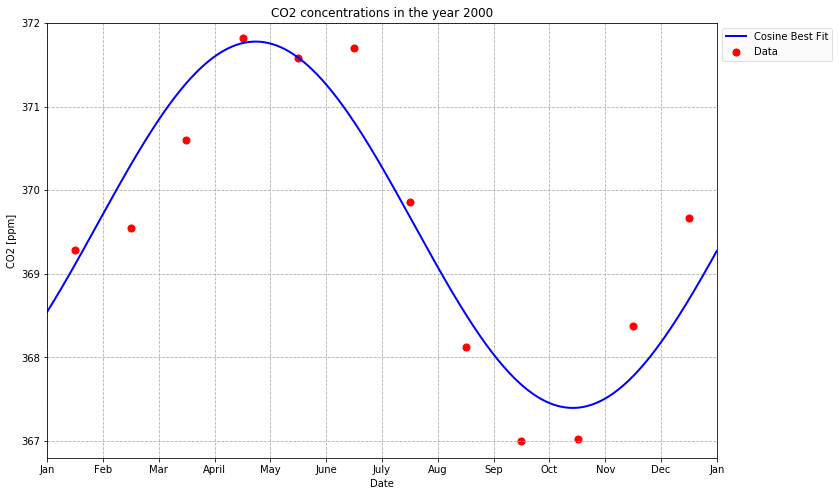

In [8]:
#Cast data to numpy arrays
ddate_2k_ar = np.array(ddate_2k)
interpolated_2k_ar = np.array(interpolated_2k)

cosine_params_2k = scipy.optimize.minimize(cosine_fit, cosine_parameters_estimate, 
                                        (ddate_2k_ar, interpolated_2k_ar, True), method = 'Nelder-Mead')
#Gridlines
plt.figure(figsize=(12,8))
plt.axis([2000, 2001, 366.8, 372])
xticks = [(x/12)+2000.0 for x in np.arange(0,13,1)]
xlabels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']
plt.xticks(xticks, xlabels)
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Date')
plt.ylabel('CO2 [ppm]')
plt.title("CO2 concentrations in the year 2000")

#Plot the data
plt.scatter(ddate_2k, interpolated_2k, s = 50, c = 'red', label = 'Data')

#Plot the fit
t = np.linspace(2000, 2001, 500)
cosine_fit_vals = general_cosine(t, cosine_params_2k.x, True)
plt.plot(t, cosine_fit_vals, lw = 2, c = 'blue', label = "Cosine Best Fit")

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

Over a small time frame such as a year, the $CO_2$ concentration fluctuates quite a bit. It is likely that many different factors influence the concentration fluctations over such a brief time. The cosine fit over a year seems to follow the data points, though it is difficult to tell how 'tight' the fit is.

### Task 2b - Fitting with annual and semi-annual harmonics and a polynomial of degree 2

Now we will fit all of the data with a combination of an annual harmonic, a semi-annual harmonic and a polynomial of degree 2 to account for the overall trend of the data. Let us adjust the functions in task 2a to include this second degree polynomial.

In [9]:
def cosine_2degpoly_fit(params, *args):
    amplitudeA, periodA, phaseA, amplitudeB, periodB, phaseB = params
    use_offset = args[-1]
    t, y_data, poly_coeffs = args[:-1]
    harmonic1 = general_cosine(t, (amplitudeA, periodA, phaseA), use_offset)
    harmonic2 = general_cosine(t, (amplitudeB, periodB/2, phaseB), use_offset)
    deg2poly = np.polyval(poly_coeffs, t)
    y_model = harmonic1 + harmonic2 + deg2poly
    residuals = y_model - y_data
    chi = np.sum(residuals**2)
    return chi

def best_fit_cospoly(xdata, ydata, params_estimate, calc_function, *args):
    poly_coeffs = np.polyfit(xdata, ydata, 2) #Fit all data with polynomial degree 2
    cosine_2degpoly_params = scipy.optimize.minimize(cosine_2degpoly_fit, params_estimate, 
                                        (xdata, ydata, poly_coeffs, False), method = 'Nelder-Mead',
                                                options = {'maxiter': 5000}, tol = 1e-18)
    if calc_function == True:
        t = args[0]
        harmonic1_fit_vals = general_cosine(t, cosine_2degpoly_params.x[0:3], False)
        harmonic2_fit_vals = general_cosine(t, cosine_2degpoly_params.x[3:6], False)
        cosine_2degpoly_fit_vals = harmonic1_fit_vals + harmonic2_fit_vals + np.polyval(poly_coeffs, t) #Add the fits
        return cosine_2degpoly_fit_vals, cosine_2degpoly_params
    else:
        return cosine_2degpoly_params

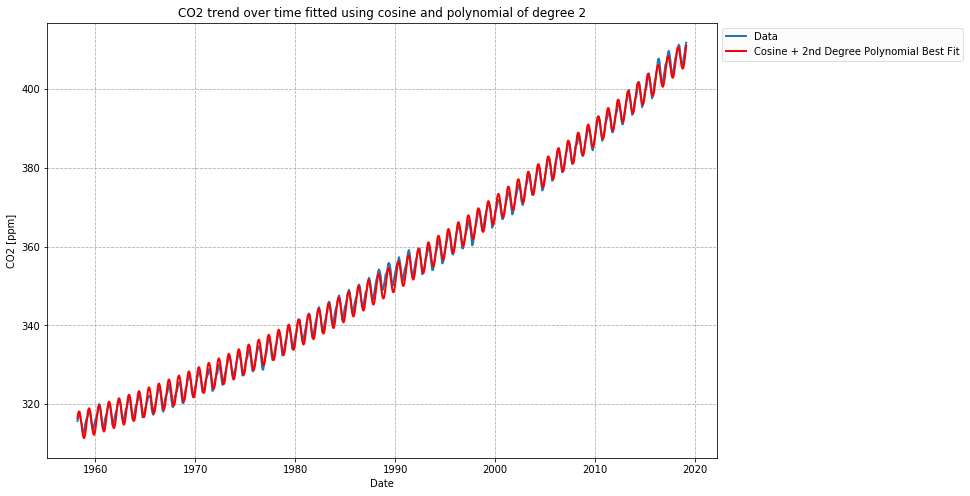

In [10]:
#Cast data to numpy arrays
ddate_data_ar = np.array(ddate_data)
interpolated_data_ar = np.array(interpolated_data)

#Gridlines
plt.figure(figsize=(12,8))
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Date')
plt.ylabel('CO2 [ppm]')
plt.title("CO2 trend over time fitted using cosine and polynomial of degree 2")

#Plot the data
plt.plot(ddate_data, interpolated_data, lw = 2, label = 'Data')

#Plot the fit
t = np.linspace(ddate_data[0], ddate_data[-1], 5000)
#Rough estimates for initial values found by trial and error for minimum x^2 value
cosine_parameters_estimate = [-3, 1, 0, 3, 1, 0.5]
cosine_2degpoly_fit_vals = best_fit_cospoly(ddate_data_ar, interpolated_data_ar, cosine_parameters_estimate, True, t)[0]
plt.plot(t, cosine_2degpoly_fit_vals, lw = 2, c = 'red', label = "Cosine + 2nd Degree Polynomial Best Fit")

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

Clearly the sum of the periodic cosine and the 2nd degree polynomial fit matches the data very closely. The periodic cosine accounts for annual fluctuation whilst the 2nd degree polynomial accounts for the overall trend. It should be noted that if an 'anomaly' year is used to produce the periodic cosine fit, the annual fluctuations will not be accounted for so nicely, although the overall trend will still be matched by the 2nd degree polynomial fit.

Now let us plot the residuals and calculate the value of $\chi^2$.

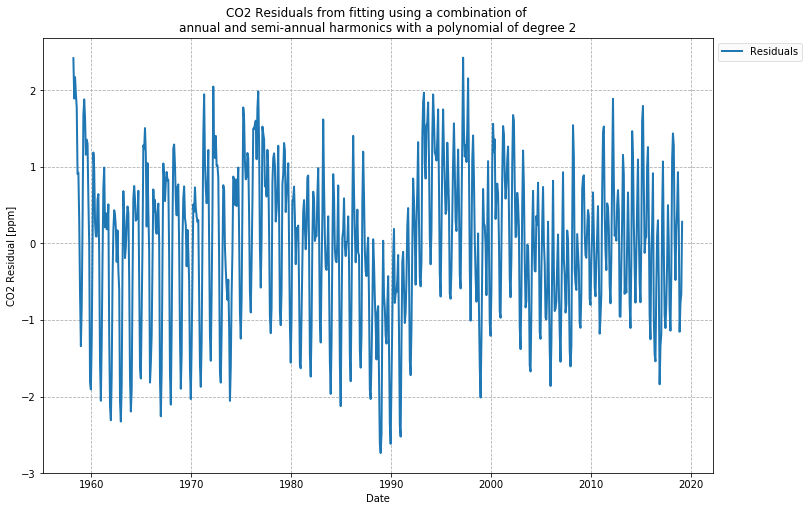

The final parameters used were:  [-2.80713274e+00  9.98398420e-01  2.80476877e-03] 
 				 [0.76875838 1.00076099 0.74736396]
The x^2 value of the cosine + degree 2 polynomial fit is x = 716.87


In [11]:
#Gridlines
plt.figure(figsize=(12,8))
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Date')
plt.ylabel('CO2 Residual [ppm]')
plt.title("CO2 Residuals from fitting using a combination of \nannual and semi-annual harmonics with a polynomial of degree 2")

#Plot the residuals
cosine_2degpoly_params = best_fit_cospoly(ddate_data_ar, interpolated_data_ar, cosine_parameters_estimate, False)
harmonic1_fit_vals = general_cosine(ddate_data, cosine_2degpoly_params.x[0:3], False)
harmonic2_fit_vals = general_cosine(ddate_data, cosine_2degpoly_params.x[3:6], False)
cosine_2degpoly_fit_vals = harmonic1_fit_vals + harmonic2_fit_vals + np.polyval(poly_coeffs, ddate_data)
residuals = cosine_2degpoly_fit_vals - interpolated_data
chi_cos_2degpoly = sum(residuals**2) #Calculate chi^2
plt.plot(ddate_data, residuals, lw = 2, label = 'Residuals')

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

print('The final parameters used were: ', cosine_2degpoly_params.x[0:3], '\n \t\t\t\t', cosine_2degpoly_params.x[3:6])
print('The x^2 value of the cosine + degree 2 polynomial fit is x = %0.2f' %chi_cos_2degpoly)

Using just the 2nd degree polynomial to fit the data yielded a $\chi^2$ value of $\chi^2 = 3573$. Adding the annual and semi-annual harmonics greatly improved the accuracy of the fit to a $\chi^2$ value of $\chi^2 = 717$. One could continue to add more harmonics (Fourier series) to improve accuracy. One could also use a higher degree polynomial. Although as we saw in task 1, the difference between a 2nd degree polynomial and a 5th degree polynomial fit was $\Delta\chi^2 = 166$ and increasing the degree further would yield diminishing returns.

## Task 3 - Sensitivity of Parameters

Estimate the sensitivity of the parameters of the "combined" model (polynomial + harmonics) parameters. Do this by repeatedly fitting the original measurements plus random components. Use the standard deviation of each parameter as a measure of uncertainty.

In [12]:
params_stack = [] #List to keep track of parameters for varying inputs of data

data1 = np.array([list(item) for item in data]) #Format data for easier generation of random data
xdata, ydata = data1[:,0], data1[:,1] #Sepearte dates and interpolated data

for i in range(200): #Perform fits to random components i times
    data_error = np.random.randn(data1.shape[0], 1) #Random array to offset interpolated data / y data
    cosine_2degpoly_error_params = best_fit_cospoly(xdata, ydata + data_error, cosine_parameters_estimate, False)
    params_stack.append(cosine_2degpoly_error_params.x)
    
params_stack = np.array(params_stack)
params_mean = np.mean(params_stack, axis = 0)
params_std = np.std(params_stack, axis = 0)

param_names = ['Amplitude A', 'Period A', 'Phase A', 'Amplitude B', 'Period B', 'Phase B']
for i, param in enumerate(param_names):
    print(param, '\t Mean:', params_mean[i], '\t Standard Dev:', params_std[i])

Amplitude A 	 Mean: -3.6499725605162716 	 Standard Dev: 1.4449804120356273
Period A 	 Mean: 0.9998788684336304 	 Standard Dev: 0.0003006881673649087
Phase A 	 Mean: -0.0014663809894954409 	 Standard Dev: 0.004736153523584937
Amplitude B 	 Mean: 3.149122430044006 	 Standard Dev: 1.1716346925286667
Period B 	 Mean: 1.0003405792500655 	 Standard Dev: 0.00013936146214558199
Phase B 	 Mean: 0.6162282288350663 	 Standard Dev: 0.5188964716433926


Analyzing the standard deviations for the parameters, we expect the more iterations performed, the closer the standard deviation of parameters should get to 0.  The reason they are not 0 is likely due to only performing the analysis 200 times, due to insanely large computation times (I attempted to analyze over 1000 iterations but after over 15 hours of continuous computing I decided to go to 200). It should also be noted that the error introduced to the data only effects the CO2 values and not the dates of measurements, therefore we expect that the amplitude parameter of the annual and semi-annual harmonics will be primarily effected. The analysis shows this is indeed the case.

## Task 4 - Extrapolating to 2100

Use a similar "monte carlo" approach to estimate the sensitivity of the combined model values of CO2 extrapolated to 2100.

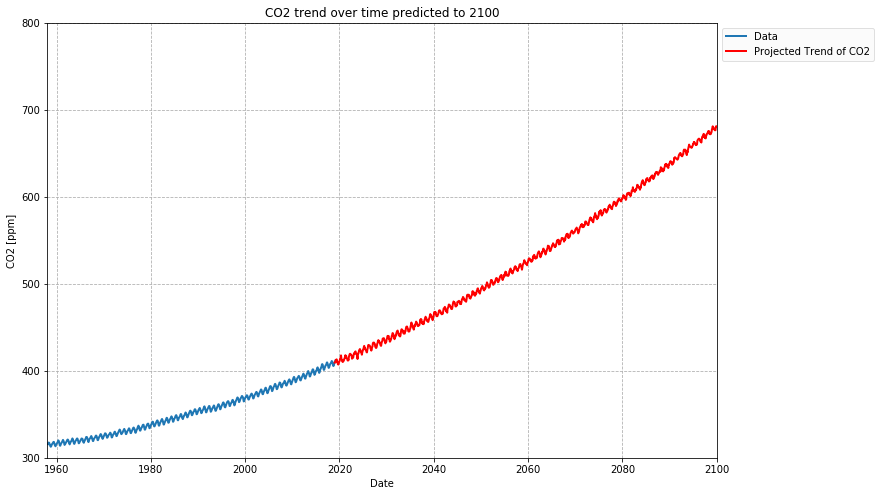

In [13]:
#Gridlines
plt.figure(figsize=(12,8))
plt.grid(linestyle='dashed')
#Labels
plt.axis([1958, 2100, 300, 800])
plt.xlabel('Date')
plt.ylabel('CO2 [ppm]')
plt.title("CO2 trend over time predicted to 2100")

#Plot the data
plt.plot(ddate_data, interpolated_data, lw = 2, label = 'Data')

#Domain of projected data
t = np.linspace(2019, 2100, 12*(2100 - 2019))

#Rough estimates for initial values found by trial and error for minimum x^2 value
cosine_parameters_estimate = [-3, 1, 0, 3, 1, 0.5]
#Generate predicted values using best fit trend line from task 2b
cosine_2degpoly_fit_vals = best_fit_cospoly(ddate_data_ar, interpolated_data_ar, cosine_parameters_estimate, True, t)[0]

#Generate some randomness to the data
vals_with_errors = []
data_error = np.random.randn(t.shape[0], 1)
for i in range(len(cosine_2degpoly_fit_vals)):
    vals_with_errors.append(cosine_2degpoly_fit_vals[i] + data_error[i])

plt.plot(t, vals_with_errors, lw = 2, c = 'red', label = "Projected Trend of CO2")

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

The random error introduced to the extrapolated dates does not effect the 2nd degree polynomial trend. Therefore disregarding the yearly fluctation of CO2, we can estimate that in the year 2100 CO2 values will be approximately 680-690 ppm.

## Conclusion

From the course we have learned how to numerically analyze different systems and interpret results from performing numerical analysis. We have applied many tools we have learned in this last final assignment to take real life data and perform an analysis. We looked at what determines a line of best fit and how can we improve our models of data in order to then make a prediction based solely on data. Ultimately we learn that numerical analysis of data can sidestep the use of theoretical models for a system and provides a different way of making predictions of physical phenomena in the future.